In [1]:
# simple RNN, BPTT vs truncated BPTT

import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np


In [2]:
bs = 1024
mu = 1
x0 = torch.randn(bs,1) + mu
print(x0.shape)

# f_theta(x) = x + theta
def f(x,theta):
    return x + theta

torch.Size([1024, 1])


tensor([1.], requires_grad=True)
init theta tensor([1.], requires_grad=True)
init loss is tensor(2909.3611, grad_fn=<AddBackward0>)
init true_grad is tensor([5740.], grad_fn=<AddBackward0>)
final theta after BPTT is tensor([-0.0030], requires_grad=True)


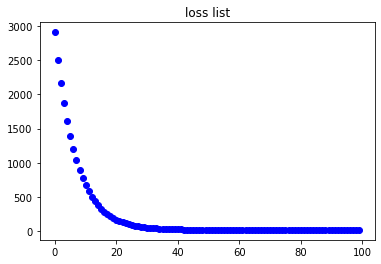

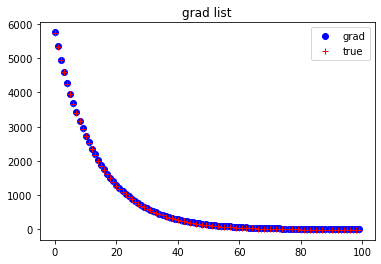

In [8]:
# OPTIMIZE WITH BPTT
theta = torch.tensor([1.0], requires_grad=True) # 
print(theta)

T = 20
print('init theta',theta)
loss_lst = []
grad_lst = []
true_grad_lst = []
maxite = 100
eta = 0.1
etat = eta / (T**3) # STEP SIZE
for ite in range(1,maxite+1):    
    xt =  x0
    losst = 0
    for t in range(1,T+1):
        xt = f(xt,theta)
        losst += torch.mean((xt - mu)**2)

    if ite == 1:
        print('init loss is',losst)
    
    loss_lst.append(losst)
    losst.backward()
    
    grad_lst.append(theta.grad.item())
    true_grad = 0
    for t in range(1,T+1):
        true_grad += 2 * t * t * theta 
    true_grad_lst.append(true_grad)
    
    if ite == 1:
        print('init true_grad is',true_grad)
    
    theta.data.add_(-etat,theta.grad)    
    
    theta.grad.zero_()
    
plt.figure()
plt.plot(loss_lst,'ob')
plt.title('loss list')

plt.figure()
plt.plot(grad_lst,'ob')
plt.plot(true_grad_lst,'r+')
plt.legend(['grad','true'])
plt.title('grad list')
print('final theta after BPTT is',theta)

init theta tensor([1.], requires_grad=True)


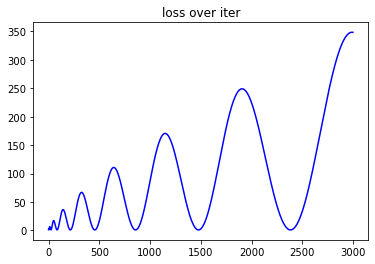

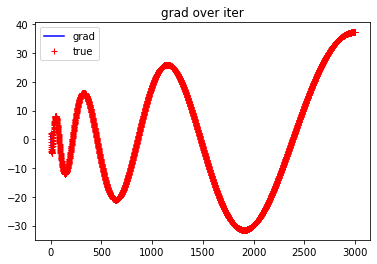

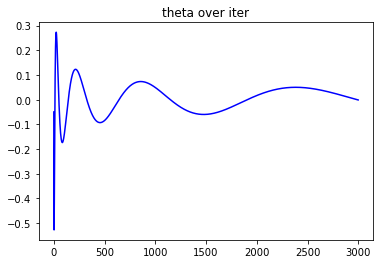

In [6]:
# OPTIMIZE WITH trucated BPTT

theta = torch.tensor([1.0], requires_grad=True) # 
print('init theta',theta)

maxite = 3000
theta_lst = []
theta_lst.append(theta.item())
for restart in range(1):
    xt =  x0
    
    loss_lst = []
    grad_lst = []
    true_grad_lst = []
    theta_lst = []

    for ite in range(1,maxite+1):
        xt = xt.detach()
        xt = f(xt,theta)
        losst = torch.mean((xt - mu)**2)
        losst.backward()    

        loss_lst.append(losst.item())
        grad_lst.append(theta.grad.item())    
        true_grad = 2 * torch.mean((xt - mu))
        true_grad_lst.append(true_grad)

        # STEP SIZE
        # etat = 0.5 # not work
        # etat = 0.1 # not work, strong ossillations
        # etat = pow(ite,0.5)  # similar slow, then blow up, not work    
        # etat = 0.5 * pow(ite,0.5) # still blow up, not work  
        etat = 0.5 * pow(ite,-3/2) # slow cvg
        #etat = 0.5 / ite # theta not sure any cvg    

        theta.data.add_(-etat,theta.grad)    
        theta_lst.append(theta.item())
        theta.grad.zero_()
    
    plt.figure()
    plt.plot(loss_lst,'b')
    plt.title('loss over iter')

    plt.figure()
    plt.plot(grad_lst,'b')
    plt.plot(true_grad_lst,'r+')
    plt.legend(['grad','true'])
    plt.title('grad over iter')
    
    plt.figure()
    plt.plot(theta_lst,'b')
    plt.title('theta over iter')
    

init theta tensor([1.], requires_grad=True)


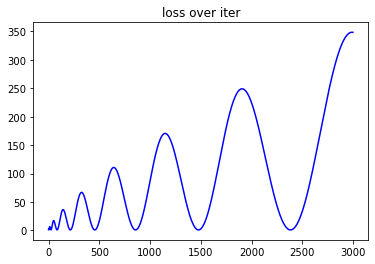

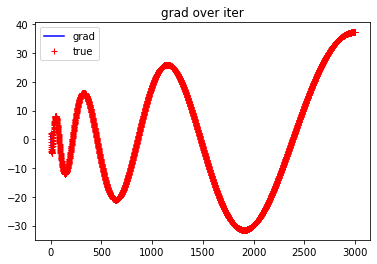

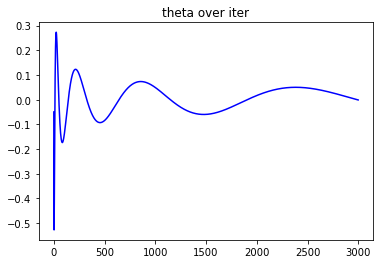

In [7]:
# SGD scheduler for trucated BPTT

theta = torch.tensor([1.0], requires_grad=True) # 
print('init theta',theta)

maxite = 3000
theta_lst = []
theta_lst.append(theta.item())
optimizer = torch.optim.SGD([theta],lr= 1 )

lambda1 = lambda ite: 0.5 * pow(ite+1,-3/2)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

for restart in range(1):
    xt =  x0

    loss_lst = []
    grad_lst = []
    true_grad_lst = []
    theta_lst = []

    for ite in range(1,maxite+1):
        optimizer.zero_grad()

        xt = xt.detach()
        xt = f(xt,theta)
        losst = torch.mean((xt - mu)**2)
        losst.backward()    

        optimizer.step()
        scheduler.step()
        
        loss_lst.append(losst.item())
        grad_lst.append(theta.grad.item())    
        true_grad = 2 * torch.mean((xt - mu))
        true_grad_lst.append(true_grad)

        theta_lst.append(theta.item())
    
    plt.figure()
    plt.plot(loss_lst,'b')
    plt.title('loss over iter')

    plt.figure()
    plt.plot(grad_lst,'b')
    plt.plot(true_grad_lst,'r+')
    plt.legend(['grad','true'])
    plt.title('grad over iter')
    
    plt.figure()
    plt.plot(theta_lst,'b')
    plt.title('theta over iter')
    
